In [34]:
# Import Packages
import pandas as pd
from pandas import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import warnings; warnings.simplefilter('ignore')

In [35]:
def parser(s):
    return datetime.strptime(s, "%Y-%m-%d")

In [36]:
# Load Data
data = pd.read_csv('/datc/parcel/notebooks/data/postnl/20201014_300_klanten.csv', parse_dates=[0])

In [37]:
cust_filter = data['cust_id'] == 'klant_69'
date_filter = data['procesdag'].dt.dayofweek <= 4
data = data.where(date_filter & cust_filter).dropna()
#data = data.where(cust_filter).dropna()

data['procesdag']=pd.to_datetime(data['procesdag'])
data = data.set_index(data.procesdag, drop=True)
data = data['2015-01-01':'2020-01-01']

In [38]:
data.drop(['procesdag'], axis='columns', inplace=True)
data.drop(['aantal_pakketten_volgende_dag'], axis='columns', inplace=True)

In [39]:
data.head()

,cust_id,aantal_pakketten,validation_column
procesdag,,,
2015-01-02,klant_69,400.0,train
2015-01-05,klant_69,337.0,train
2015-01-06,klant_69,328.0,train
2015-01-07,klant_69,157.0,train
2015-01-08,klant_69,304.0,train


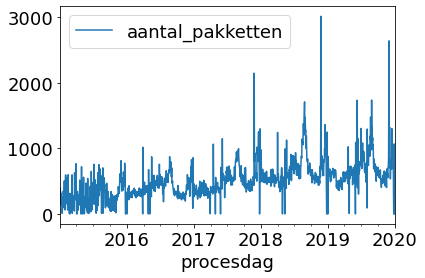

In [40]:
data.plot()

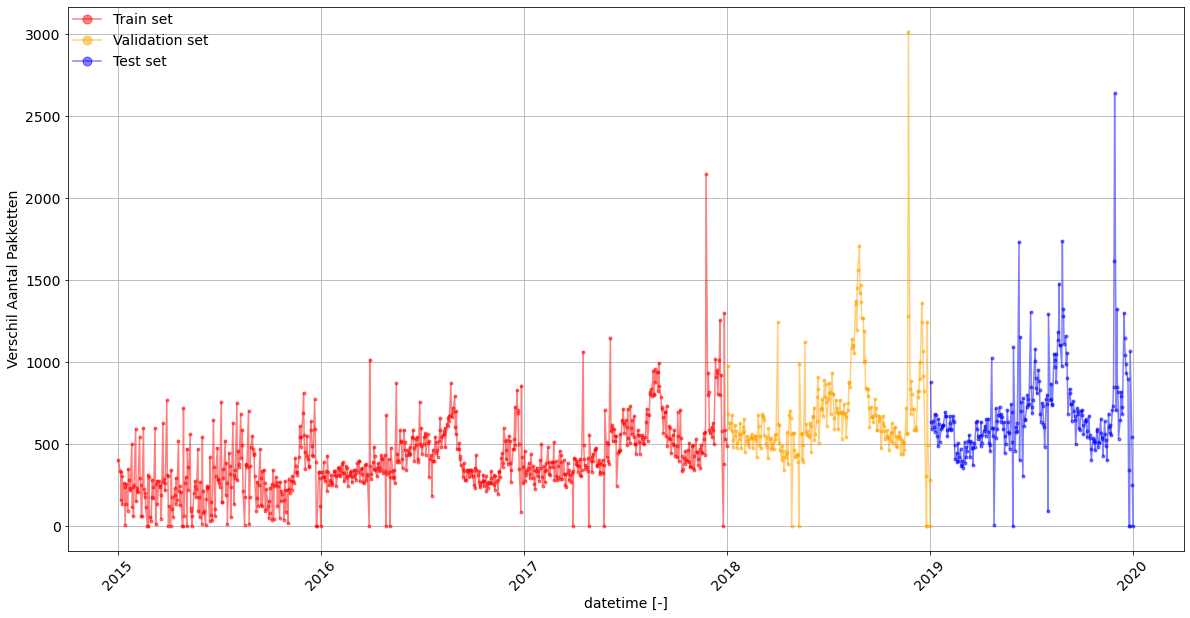

In [41]:
from sklearn.model_selection import train_test_split
data_pak = data['aantal_pakketten']
y = data_pak[:'2020-01-01'].values
X = data.index

train_size = 0.60
val_size = 0.20
test_size = 0.20

split_index_val = int(data.shape[0]*(train_size))
split_index_test = int(data.shape[0]*(train_size+val_size))

X_train = X[:split_index_val]
X_val = X[split_index_val:split_index_test]
X_test = X[split_index_test:]

y_train = y[:split_index_val]
y_val = y[split_index_val:split_index_test]
y_test = y[split_index_test:]

X_train_values = data[:split_index_val] # get the datetime values of X_train
X_val_values = data[split_index_val:split_index_test]
X_test_values = data[split_index_test:]

plt.figure(figsize=(20,10))

plt.plot(X_train_values.index, y_train, '.-', color='red', label='Train set', alpha=0.5)
plt.plot(X_val_values.index, y_val, '.-', color='orange', label='Validation set', alpha=0.5)
plt.plot(X_test_values.index, y_test, '.-', color='blue', label='Test set', alpha=0.5)

plt.ylabel(r'Verschil Aantal Pakketten', fontsize=14)
plt.xlabel('datetime [-]', fontsize=14)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)
plt.grid()

In [42]:
train_end = datetime(2018,1,1)
val_end = datetime(2019,1,1)

train_data = data_pak[:train_end]
val_data = data_pak[train_end + timedelta(days=1):val_end]

from statsmodels.tsa.statespace.sarimax import SARIMAX
my_order = (1,0,1)
my_seasonal_order = (0, 1, 1, 12)

rolling_predictions = val_data.copy()
for train_end in val_data.index:
    train_data = data_pak[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()
    
    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

Text(0.5, 1.0, 'Rolling Window Validatie Klant 69')

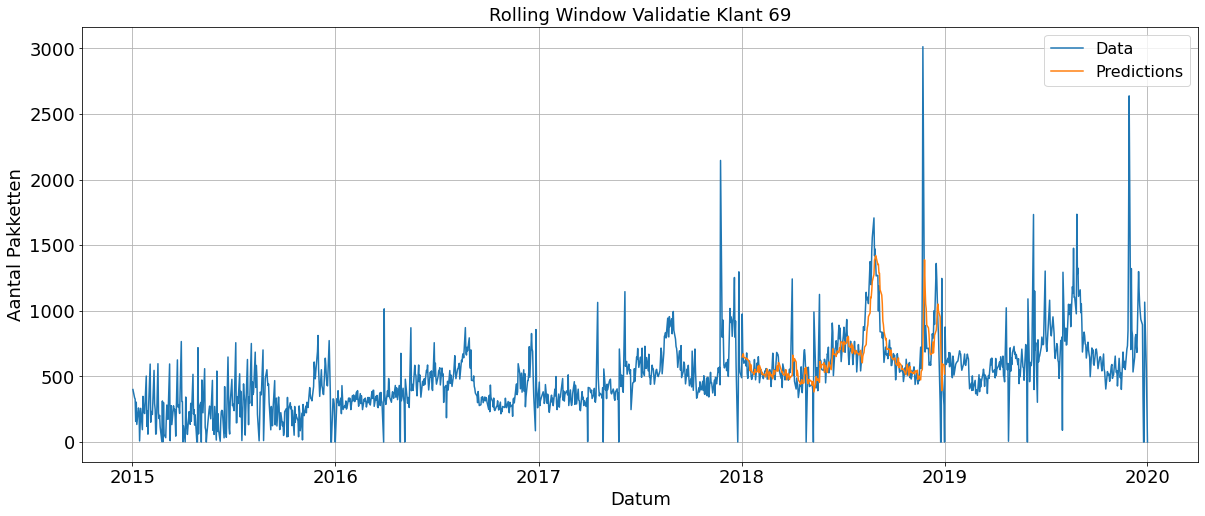

In [43]:
plt.figure(figsize=(20,8))

plt.plot(data_pak[:'2020-01-01'])
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)
plt.grid()
plt.xlabel('Datum',fontsize= 18)
plt.ylabel('Aantal Pakketten',fontsize= 18)
plt.title('Rolling Window Validatie Klant 69',fontsize= 18)
#residuals = data_diff - model_fit.fittedvalues
#print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

RMSE: 176.19783552717064
MAE: 97.69447458662941
R2: 0.6313787278325675


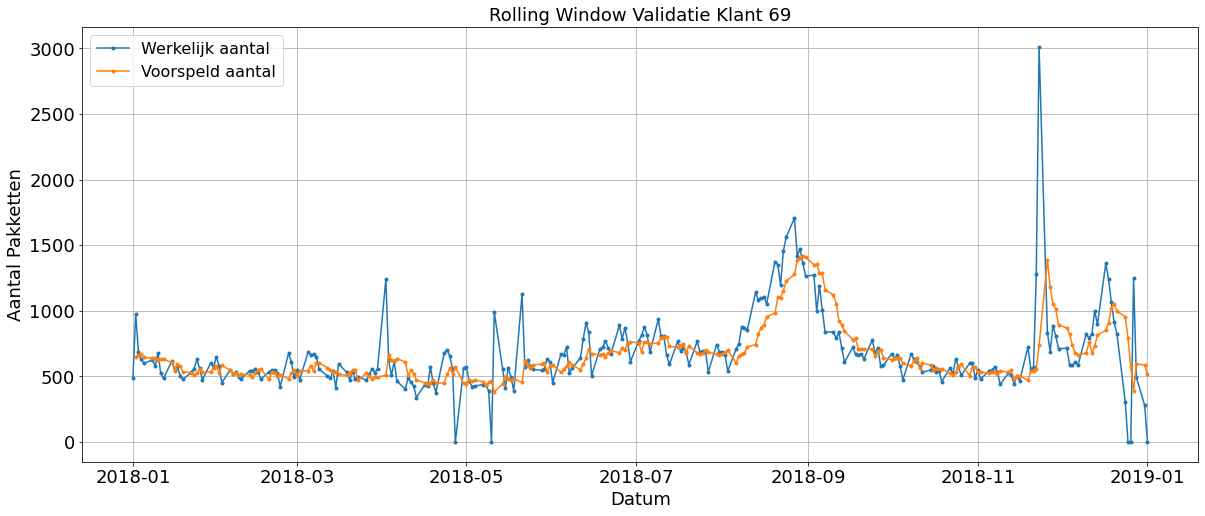

In [51]:
from sklearn import metrics
plt.figure(figsize=(20,8))

plt.rcParams.update({'font.size': 18})
plt.plot(data_pak['2018-01-01':'2019-01-01'], '.-')
plt.plot(rolling_predictions, '.-')

plt.legend(('Werkelijk aantal', 'Voorspeld aantal'), fontsize=16)
plt.grid()
plt.xlabel('Datum',fontsize= 18)
plt.ylabel('Aantal Pakketten',fontsize= 18)
plt.title('Rolling Window Validatie Klant 69',fontsize= 18)
rmse = (np.sqrt(metrics.mean_squared_error(data_pak['2018-01-01':'2018-12-31'], rolling_predictions)))
mae = (metrics.mean_absolute_error(data_pak['2018-01-01':'2018-12-31'], rolling_predictions))
r2 = metrics.r2_score(data_pak['2018-01-01':'2018-12-31'], rolling_predictions)
print('RMSE:', rmse)
print('MAE:', mae)
print('R2:', r2)